In [1]:
from glob import glob
import pandas as pd
from scipy.stats import spearmanr, fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
import seaborn as sns

sns.set_context('talk')
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_style('whitegrid')

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

def measure_enrichment(sig_kos, modules, all_module_kos):
    enrichment_rows = list()
    for module, module_kos in modules.items():
        in_in = len(sig_kos & module_kos)  # in module and in gene set
        in_out = len(sig_kos - module_kos)  # in gene set and out of module
        out_in = len(module_kos - sig_kos)  # in module and out of gene set
        out_out = len(all_module_kos - module_kos - sig_kos)

        odds_ratio, p_value = fisher_exact([[in_in, in_out],
                                            [out_in, out_out]], alternative='greater')
        enrichment_rows.append([module, len(module_kos), in_in, in_out, out_in, out_out, odds_ratio, p_value])
    enrichment = pd.DataFrame(enrichment_rows, columns=['module', 'module_size', 'in_in', 'in_out', 'out_in', 'out_out', 'odds_ratio', 'p_value']).set_index('module').sort_values('p_value')
    enrichment['p_adj'] = p_adjust(enrichment['p_value'])
    return enrichment

# Correlate titers with KOs

## Read in data

In [2]:
meta = pd.read_csv('../../data/metadata/stool/stool_metadata.csv', index_col='SampleID')
meta = pd.concat([meta,
                  pd.read_csv('../../data/metadata/stool/stool_abx_usage.csv', index_col='SampleID'),
                  pd.read_csv('../../data/metadata/stool/stool_titers_yr2.csv', index_col='SampleID')],
                 axis=1)
meta = meta.query("`gt_2.5` == True")
meta['VR_group'] = meta['VR_group'].fillna('Not Measured')
meta = meta.sort_values(['BabyN', 'age_at_collection'])
meta = meta.loc[~pd.isna(meta['median_mmNorm'])]
meta.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,PCV ST9V_mmNorm,PCV ST14_mmNorm,PCV ST18C_mmNorm,PCV ST19A_mmNorm,PCV ST19F_mmNorm,PCV ST23F_mmNorm,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,VR_group
SampleID,,,,,,,,,,,,,,,,,,,,,
103_V9,Primary in Tube,186,NaN,NaN,"Box 12, B1",Stool,Human Infant,MetaG,103,NaN,...,0.277753,0.146465,0.086356,0.035467,0.057453,0.300910,0.190854,0.326317,0.146465,NVR
103_S1,Primary in Tube,225,NaN,NaN,"Box 13, B4",Stool,Human Infant,MetaG,103,NaN,...,0.277753,0.146465,0.086356,0.035467,0.057453,0.300910,0.190854,0.326317,0.146465,NVR
103_V10,Primary in Tube,241,NaN,NaN,"Box 13, E1",Stool,Human Infant,MetaG,103,NaN,...,0.277753,0.146465,0.086356,0.035467,0.057453,0.300910,0.190854,0.326317,0.146465,NVR
108_V2,Primary in Tube,6,NaN,NaN,"Box 7, A6",Stool,Human Infant,MetaG,108,NaN,...,0.871843,0.366194,0.164958,0.041692,0.063590,0.371471,0.168430,0.172291,0.164958,NVR
108_V3,Primary in Tube,4,NaN,NaN,"Box 7, A4",Stool,Human Infant,MetaG,108,NaN,...,0.871843,0.366194,0.164958,0.041692,0.063590,0.371471,0.168430,0.172291,0.164958,NVR


In [3]:
ko_abunds = pd.read_csv('../../data/stool/ko_abundance_table.rel.tsv', sep='\t', index_col=0)
ko_abunds.index = [i.replace("'", "_").replace('#', '_') for i in ko_abunds.index]
ko_abunds.columns = [i.split('.txt')[0] for i in ko_abunds.columns]
ko_abunds = ko_abunds[meta.index]
print(ko_abunds.shape)
display(ko_abunds.head())

(11048, 450)


,103_V9,103_S1,103_V10,108_V2,108_V3,108_V4,108_V5,108_V6,108_V7,108_S1,...,264_V5,264_S1,264_S1F,264_V7,264_S2,264_S2F,264_V9,264_V10,264_V11,264_V12
K00001,0.000155,0.000265,2.091231e-04,0.000410,0.000490,0.000390,0.000390,0.000422,0.000464,0.000154,...,0.000490,0.000668,0.000293,3.703148e-04,0.000635,7.914440e-04,3.764422e-04,0.000187,1.659096e-04,0.000143
K00002,0.000000,0.000001,8.615558e-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.651716e-07,0.000000,2.815525e-07,6.831982e-07,0.000016,1.020476e-05,0.000007
K00003,0.000706,0.000335,8.537235e-04,0.001143,0.000789,0.000481,0.000460,0.000976,0.000710,0.000492,...,0.000716,0.000970,0.000358,4.713999e-04,0.000889,9.913462e-04,5.342610e-04,0.000521,6.297325e-04,0.000501
K00004,0.000000,0.000000,7.832326e-07,0.000007,0.000297,0.000065,0.000017,0.000000,0.000007,0.000055,...,0.000030,0.000065,0.000014,1.090133e-05,0.000007,4.645616e-06,3.415991e-07,0.000002,3.291858e-07,0.000006
K00005,0.000155,0.000083,3.164260e-04,0.000026,0.000415,0.000246,0.000448,0.000311,0.000525,0.000336,...,0.000167,0.000137,0.000366,2.578329e-04,0.000123,1.144511e-04,7.890940e-05,0.000201,2.011325e-04,0.000209


In [4]:
in_both = set(meta.index) & set(ko_abunds.columns)
meta_matched = meta.loc[in_both]
print(meta_matched.shape)

(450, 72)


/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_12921/2340599432.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  meta_matched = meta.loc[in_both]


In [5]:
meta_v5 = meta_matched.query("VisitCode == 'V5'")
meta_v6 = meta_matched.query("VisitCode == 'V6'")
meta_v7 = meta_matched.query("VisitCode == 'V7'")
meta_v9 = meta_matched.query("VisitCode == 'V9'")

In [6]:
meta_PCV = meta_matched.loc[~pd.isna(meta_matched['median_mmNorm_PCV'])]
meta_PCV.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,PCV ST9V_mmNorm,PCV ST14_mmNorm,PCV ST18C_mmNorm,PCV ST19A_mmNorm,PCV ST19F_mmNorm,PCV ST23F_mmNorm,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,VR_group
SampleID,,,,,,,,,,,,,,,,,,,,,
227_S2F,Primary in Tube,670,NaN,NaN,Box21,Stool,Human Infant,MetaG,227,NaN,...,0.271781,0.127501,0.118065,0.053218,0.024696,0.307310,0.105356,0.038992,0.118065,NVR
209_V5,Primary in Tube,29,NaN,NaN,"Box 7, E5",Stool,Human Infant,MetaG,209,NaN,...,0.089643,0.282573,0.075616,0.024911,0.012167,0.068419,0.053628,0.035388,0.075616,NVR
226_AF1,Primary in Tube,109,NaN,NaN,"Box 10, A1",Stool,Human Infant,MetaG,226,NaN,...,0.162001,0.082202,0.016803,0.043288,0.012579,0.103734,0.074301,0.097174,0.057712,NVR
130_V7,Primary in Tube,487,NaN,NaN,Box12,Stool,Human Infant,MetaG,130,NaN,...,0.628508,0.128899,0.092901,0.052755,0.021899,0.073206,0.092901,0.043521,0.118330,NVR
227_V7,Primary in Tube,168,NaN,NaN,"Box 11, E1",Stool,Human Infant,MetaG,227,NaN,...,0.271781,0.127501,0.118065,0.053218,0.024696,0.307310,0.105356,0.038992,0.118065,NVR


In [7]:
# The KEGG module file is not in the git repo, future users will need to find a copy of this file somewhere
modules = {line.strip().split()[0]: set(line.strip().split()[1:]) for line in open('../../../../KEGG.20210320/module_kos.tsv')}
modules = {key: value for key, value in modules.items() if len(value) >= 5}
all_module_kos = {ko for module, kos in modules.items() for ko in kos}
print(len(all_module_kos))

2208


## KO correlations

### 2 months

In [8]:
ko_abunds_v5 = ko_abunds[meta_v5.index]
ko_abunds_v5 = ko_abunds_v5.loc[(ko_abunds_v5 > 0).sum(axis=1) > ko_abunds_v5.shape[1]*.2]
ko_abunds_v5 = ko_abunds_v5.loc[ko_abunds_v5.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v5.shape)

(4368, 32)


In [9]:
v5_correlations = ko_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations.columns = ['rho', 'p_value']
v5_correlations['p_adj'] = p_adjust(v5_correlations['p_value'])
v5_correlations = v5_correlations.sort_values('p_value')
v5_correlations.head()

,rho,p_value,p_adj
K07464,0.560779,0.000842,0.962053
K19118,0.485495,0.004852,0.962053
K07334,0.466135,0.007167,0.962053
K19119,0.448665,0.010006,0.962053
K06994,-0.436651,0.012467,0.962053


In [10]:
print(len(v5_correlations.query('p_value < .05')))

41


When we do these correlations we get no significant after FDR correction. There is strong significance in the raw p-values though with 278 unadjusted p-values < .05. To take advantage of this result we will run a module enrichment test to look for enrichment of KEGG modules.

In [11]:
v5_sig_kos = set(v5_correlations.query('p_value < .05').index)
v5_enrichment = measure_enrichment(v5_sig_kos, modules, all_module_kos)
# v5_enrichment.to_csv('../../../data/stool_metag/ko_correlation_enrichment_V5.tsv', sep='\t')
v5_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00545,11,2,39,9,2194,12.501425,0.016143,1.0
M00346,10,1,40,9,2194,6.094444,0.168707,1.0
M00122,10,1,40,9,2194,6.094444,0.168707,1.0
M00002,12,1,40,11,2192,4.981818,0.198947,1.0
M00307,12,1,40,11,2192,4.981818,0.198947,1.0


When we do this we find 3 modules which are significantly enriched. M00060 and M00866 are the same but with 1 KO added for 866.

#### Dig into modules

In [12]:
v5_correlations.loc[set(v5_correlations.index) & modules['M00060']].sort_values('p_value')

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_12921/3075512320.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  v5_correlations.loc[set(v5_correlations.index) & modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K09949,0.202444,0.266487,0.962053
K00912,0.183284,0.315330,0.962053
K02536,0.159824,0.382245,0.962053
K00677,0.148460,0.417415,0.962053
K02517,0.120235,0.512163,0.962053
K02560,-0.093842,0.609451,0.962053
K03269,0.087977,0.632081,0.962053
K00748,0.082845,0.652155,0.962053
K02535,-0.055352,0.763498,0.963258
K02527,0.043255,0.814160,0.964279


In [13]:
v5_correlations.loc[set(v5_correlations.index) & modules['M00144']].sort_values('p_value')

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_12921/136881632.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  v5_correlations.loc[set(v5_correlations.index) & modules['M00144']].sort_values('p_value')


,rho,p_value,p_adj
K00338,0.182918,0.316315,0.962053
K00340,0.166056,0.363715,0.962053
K00337,0.163123,0.372368,0.962053
K00342,0.155792,0.394522,0.962053
K00335,-0.138930,0.448256,0.962053
K13378,0.126100,0.491642,0.962053
K00334,-0.121334,0.508283,0.962053
K00330,0.116202,0.526513,0.962053
K00339,0.112170,0.541055,0.962053
K00341,0.108504,0.554438,0.962053


In [14]:
v5_correlations.loc[set(v5_correlations.index) & modules['M00866']].sort_values('p_value')

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_12921/872333751.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  v5_correlations.loc[set(v5_correlations.index) & modules['M00866']].sort_values('p_value')


,rho,p_value,p_adj
K09949,0.202444,0.266487,0.962053
K00912,0.183284,0.315330,0.962053
K16363,0.169928,0.352475,0.962053
K02536,0.159824,0.382245,0.962053
K00677,0.148460,0.417415,0.962053
K02517,0.120235,0.512163,0.962053
K03269,0.087977,0.632081,0.962053
K00748,0.082845,0.652155,0.962053
K02535,-0.055352,0.763498,0.963258
K02527,0.043255,0.814160,0.964279


LPS, LPS and oxidative phosphorlyation? Is this hope?

### 4 months

In [15]:
ko_abunds_v6 = ko_abunds[meta_v6.index]
ko_abunds_v6 = ko_abunds_v6.loc[(ko_abunds_v6 > 0).sum(axis=1) > ko_abunds_v6.shape[1]*.2]
ko_abunds_v6 = ko_abunds_v6.loc[ko_abunds_v6.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v6.shape)

(4384, 34)


In [16]:
v6_correlations = ko_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm']).transpose()
v6_correlations.columns = ['rho', 'p_value']
v6_correlations['p_adj'] = p_adjust(v6_correlations['p_value'])
v6_correlations = v6_correlations.sort_values('p_value')
v6_correlations.head()

,rho,p_value,p_adj
K02536,-0.567609,0.000463,0.999316
K07493,-0.474465,0.004582,0.999316
K12994,-0.462484,0.005888,0.999316
K18827,-0.419464,0.013531,0.999316
K01130,-0.414209,0.014875,0.999316


In [17]:
print(len(v6_correlations.query('p_value < .05')))

43


Many fewer significant results than at 2 months but we will still look for enrichment.

In [18]:
v6_sig_kos = set(v6_correlations.query('p_value < .05').index)
v6_enrichment = measure_enrichment(v6_sig_kos, modules, all_module_kos)
v6_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00573,5,2,41,3,2198,35.739837,0.003459,0.519325
M00123,6,2,41,4,2197,26.792683,0.005125,0.519325
M00577,6,2,41,4,2197,26.792683,0.005125,0.519325
M00061,7,1,42,6,2195,8.710317,0.126826,1.000000
M00631,8,1,42,7,2194,7.462585,0.143610,1.000000


We find nothing though.

### 6 months

In [19]:
ko_abunds_v7 = ko_abunds[meta_v7.index]
ko_abunds_v7 = ko_abunds_v7.loc[(ko_abunds_v7 > 0).sum(axis=1) > ko_abunds_v7.shape[1]*.2]
ko_abunds_v7 = ko_abunds_v7.loc[ko_abunds_v7.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v7.shape)

(4260, 38)


In [20]:
v7_correlations = ko_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm']).transpose()
v7_correlations.columns = ['rho', 'p_value']
v7_correlations['p_adj'] = p_adjust(v7_correlations['p_value'])
v7_correlations = v7_correlations.sort_values('p_value')
v7_correlations.head()

,rho,p_value,p_adj
K21583,0.495662,0.001554,0.99851
K03738,0.473492,0.002677,0.99851
K18986,0.473323,0.002688,0.99851
K16907,0.469744,0.002925,0.99851
K02652,0.445235,0.005093,0.99851


In [21]:
print(len(v7_correlations.query('p_value < .05')))

42


Many fewer significant results than at 2 months but we will still look for enrichment.

In [22]:
v7_sig_kos = set(v7_correlations.query('p_value < .05').index)
v7_enrichment = measure_enrichment(v7_sig_kos, modules, all_module_kos)
v7_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00552,5,1,41,4,2201,13.420732,0.090106,1.0
M00308,7,1,41,6,2199,8.939024,0.123885,1.0
M00166,7,1,41,6,2199,8.939024,0.123885,1.0
M00309,8,1,41,7,2198,7.658537,0.140312,1.0
M00002,12,1,41,11,2194,4.864745,0.203066,1.0


We find nothing though.

### 1 year

In [23]:
ko_abunds_v9 = ko_abunds[meta_v9.index]
ko_abunds_v9 = ko_abunds_v9.loc[(ko_abunds_v9 > 0).sum(axis=1) > ko_abunds_v9.shape[1]*.2]
ko_abunds_v9 = ko_abunds_v9.loc[ko_abunds_v9.var(axis=1) > 1e-10] # variance filter
print(ko_abunds_v9.shape)

(4278, 37)


In [24]:
v9_correlations = ko_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations.columns = ['rho', 'p_value']
v9_correlations['p_adj'] = p_adjust(v9_correlations['p_value'])
v9_correlations = v9_correlations.sort_values('p_value')
v9_correlations.head()

,rho,p_value,p_adj
K07080,0.544334,0.000496,0.628968
K13626,0.543860,0.000503,0.628968
K01661,-0.543623,0.000506,0.628968
K06398,0.537459,0.000603,0.628968
K09759,0.522285,0.000914,0.628968


In [25]:
print(len(v9_correlations.query('p_value < .05')))

197


At one year there is a large number of significant KOs. An alarmingly large number.

In [26]:
v9_sig_kos = set(v9_correlations.query('p_value < .05').index)
v9_enrichment = measure_enrichment(v9_sig_kos, modules, all_module_kos)
v9_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00545,11,4,193,7,2170,6.424870,0.009531,1.0
M00159,9,3,194,6,2171,5.595361,0.032499,1.0
M00616,5,2,195,3,2174,7.432479,0.057947,1.0
M00377,10,2,195,8,2169,2.780769,0.198762,1.0
M00356,19,3,194,16,2161,2.088595,0.205074,1.0


But after testing for enrichment none is found.

## Break down titers into DTapHib and PCV

We will go back through and do the same correlations but splitting median titer into median DTAPHib titer and median PCV titer.

### 2 months

In [27]:
v5_DTAPHib_correlations = ko_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations.columns = ['rho', 'p_value']
v5_DTAPHib_correlations['p_adj'] = p_adjust(v5_DTAPHib_correlations['p_value'])
v5_DTAPHib_correlations = v5_DTAPHib_correlations.sort_values('p_value')
v5_DTAPHib_correlations.head()

,rho,p_value,p_adj
K21645,-0.518328,0.002374,0.419946
K02473,0.509313,0.002909,0.419946
K19355,0.494155,0.004045,0.419946
K01689,0.490103,0.004407,0.419946
K09973,-0.486070,0.004794,0.419946


In [28]:
print(len(v5_DTAPHib_correlations.query('p_value < .05')))

219


In [29]:
v5_DTAPHib_sig_kos = set(v5_DTAPHib_correlations.query('p_value < .05').index)
v5_DTAPHib_enrichment = measure_enrichment(v5_DTAPHib_sig_kos, modules, all_module_kos)
v5_DTAPHib_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00793,5,3,216,2,2186,15.180556,0.006472,1.0
M00133,7,2,217,5,2183,4.023963,0.127586,1.0
M00596,5,1,218,4,2184,2.504587,0.379595,1.0
M00007,6,1,218,5,2183,2.002752,0.436160,1.0
M00046,6,1,218,5,2183,2.002752,0.436160,1.0


Nothing is significantly associated with DTAPHib at 2 months.

In [30]:
meta_PCV_v5 = meta_PCV.query("VisitCode == 'V5'")
ko_abunds_PCV_v5 = ko_abunds_v5[meta_PCV_v5.index]
ko_abunds_PCV_v5 = ko_abunds_PCV_v5.loc[(ko_abunds_PCV_v5 > 0).sum(axis=1) > ko_abunds_PCV_v5.shape[1]*.2]
v5_PCV_correlations = ko_abunds_PCV_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations.columns = ['rho', 'p_value']
v5_PCV_correlations['p_adj'] = p_adjust(v5_PCV_correlations['p_value'])
v5_PCV_correlations = v5_PCV_correlations.sort_values('p_value')
v5_PCV_correlations.head()

,rho,p_value,p_adj
K07464,0.482557,0.005155,0.999555
K07334,0.455870,0.008738,0.999555
K02068,-0.450880,0.009601,0.999555
K01941,-0.440367,0.011657,0.999555
K03885,0.438783,0.011997,0.999555


In [31]:
print(len(v5_PCV_correlations.query('p_value < .05')))

38


In [32]:
v5_PCV_sig_kos = set(v5_PCV_correlations.query('p_value < .05').index)
v5_PCV_enrichment = measure_enrichment(v5_PCV_sig_kos, modules, all_module_kos)
v5_PCV_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00609,6,1,37,5,2197,11.875676,0.097670,1.0
M00124,6,1,37,5,2197,11.875676,0.097670,1.0
M00049,9,1,37,8,2194,7.412162,0.142956,1.0
M00529,10,1,37,9,2193,6.585586,0.157554,1.0
M00346,10,1,37,9,2193,6.585586,0.157554,1.0


The three modeuls identified previously are associatd with PCV and not DTAPHib at 2 months.

In [33]:
m00060_ko_correlations = v5_PCV_correlations.loc[modules['M00060']].sort_values('p_value')
m00060_ko_correlations

/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_12921/3837576614.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  m00060_ko_correlations = v5_PCV_correlations.loc[modules['M00060']].sort_values('p_value')


,rho,p_value,p_adj
K09949,0.126897,0.488884,0.999555
K02536,0.121701,0.506993,0.999555
K00677,0.113270,0.537070,0.999555
K00912,0.106672,0.561187,0.999555
K02517,0.096408,0.599659,0.999555
K03269,0.075513,0.681249,0.999555
K00748,0.046921,0.798720,0.999555
K02527,0.032625,0.859306,0.999555
K02535,0.028226,0.878125,0.999555
K02560,0.024194,0.895433,0.999555


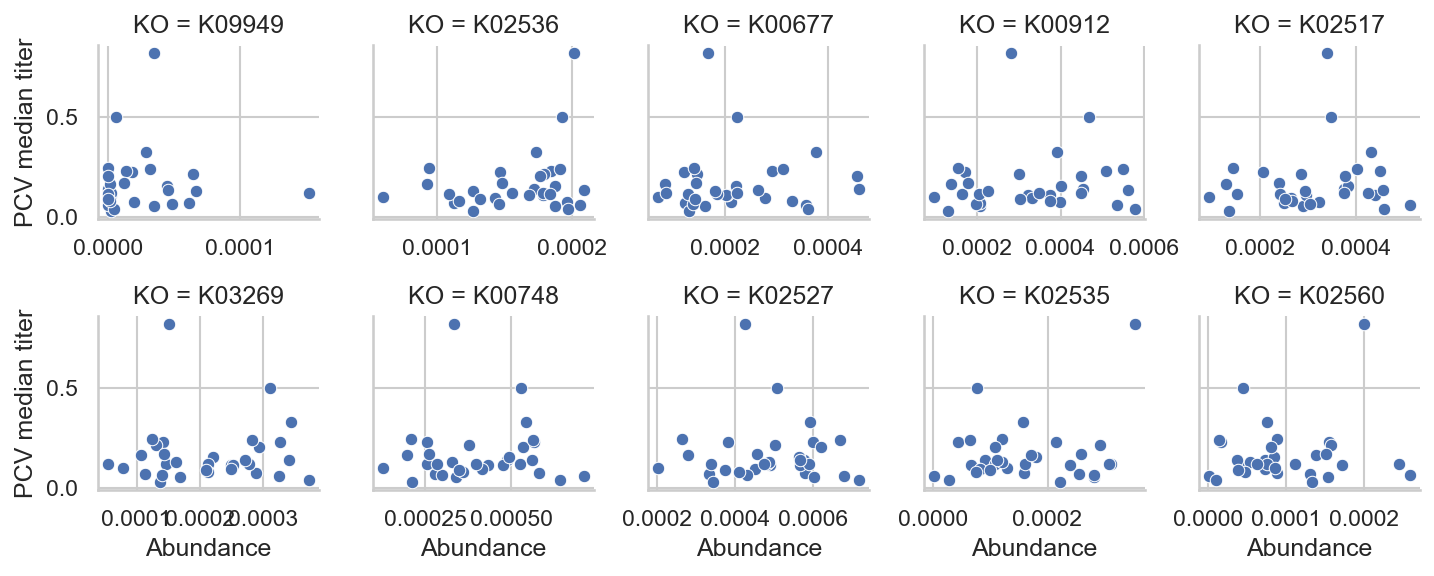

In [34]:
m00060_ko_abunds = ko_abunds_PCV_v5.loc[m00060_ko_correlations.index].unstack().reset_index()
m00060_ko_abunds.columns = ['Sample', 'KO', 'Abundance']
m00060_ko_abunds['PCV median titer'] = [meta_PCV_v5.loc[sample, 'median_mmNorm_PCV'] for sample in m00060_ko_abunds['Sample'].values]
g = sns.FacetGrid(m00060_ko_abunds, col="KO", col_wrap=5, height=2, sharex=False)
_ = g.map(sns.scatterplot, "Abundance", "PCV median titer")

The first 7 plots here are from significant KOs. Not super compelling but it is significant.

## 4 months

In [35]:
v6_DTAPHib_correlations = ko_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm_DTAPHib']).transpose()
v6_DTAPHib_correlations.columns = ['rho', 'p_value']
v6_DTAPHib_correlations['p_adj'] = p_adjust(v6_DTAPHib_correlations['p_value'])
v6_DTAPHib_correlations = v6_DTAPHib_correlations.sort_values('p_value')
v6_DTAPHib_correlations.head()

,rho,p_value,p_adj
K18827,-0.518252,0.001691,0.976923
K12994,-0.515988,0.001786,0.976923
K16516,-0.508146,0.002154,0.976923
K09022,-0.495072,0.002913,0.976923
K13327,0.478900,0.004166,0.976923


In [36]:
v6_DTAPHib_sig_kos = set(v6_DTAPHib_correlations.query('p_value < .05').index)
v6_DTAPHib_enrichment = measure_enrichment(v6_DTAPHib_sig_kos, modules, all_module_kos)
v6_DTAPHib_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00802,5,1,63,4,2196,8.714286,0.133686,1.0
M00552,5,1,63,4,2196,8.714286,0.133686,1.0
M00019,6,1,63,5,2195,6.968254,0.158229,1.0
M00565,7,1,63,6,2194,5.804233,0.182088,1.0
M00166,7,1,63,6,2194,5.804233,0.182088,1.0


In [37]:
meta_PCV_v6 = meta_PCV.query("VisitCode == 'V6'")
ko_abunds_PCV_v6 = ko_abunds_v6[meta_PCV_v6.index]
ko_abunds_PCV_v6 = ko_abunds_PCV_v6.loc[(ko_abunds_PCV_v6 > 0).sum(axis=1) > ko_abunds_PCV_v6.shape[1]*.2]
v6_PCV_correlations = ko_abunds_PCV_v6.transpose().apply(spearmanr, b=meta_PCV_v6['median_mmNorm_PCV']).transpose()
v6_PCV_correlations.columns = ['rho', 'p_value']
v6_PCV_correlations['p_adj'] = p_adjust(v6_PCV_correlations['p_value'])
v6_PCV_correlations = v6_PCV_correlations.sort_values('p_value')
v6_PCV_correlations.head()

,rho,p_value,p_adj
K02536,-0.478075,0.004241,0.999316
K01039,0.471220,0.004908,0.999316
K01758,0.454434,0.006936,0.999316
K00899,0.442934,0.008706,0.999316
K05020,0.441378,0.008972,0.999316


In [38]:
v6_PCV_sig_kos = set(v6_PCV_correlations.query('p_value < .05').index)
v6_PCV_enrichment = measure_enrichment(v6_PCV_sig_kos, modules, all_module_kos)
v6_PCV_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00060,10,2,44,8,2191,12.448864,0.016650,1.0
M00122,10,2,44,8,2191,12.448864,0.016650,1.0
M00866,11,2,44,9,2190,11.060606,0.020087,1.0
M00573,5,1,45,4,2195,12.194444,0.098421,1.0
M00052,6,1,45,5,2194,9.751111,0.116935,1.0


Nothing significant at 4 months.

### 6 months

In [39]:
v7_DTAPHib_correlations = ko_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm_DTAPHib']).transpose()
v7_DTAPHib_correlations.columns = ['rho', 'p_value']
v7_DTAPHib_correlations['p_adj'] = p_adjust(v7_DTAPHib_correlations['p_value'])
v7_DTAPHib_correlations = v7_DTAPHib_correlations.sort_values('p_value')
v7_DTAPHib_correlations.head()

,rho,p_value,p_adj
K13287,0.523793,0.000738,0.955324
K00868,-0.462523,0.003458,0.955324
K13285,0.454515,0.004148,0.955324
K02520,0.449612,0.004626,0.955324
K18986,0.430893,0.006919,0.955324


In [40]:
v7_DTAPHib_sig_kos = set(v7_DTAPHib_correlations.query('p_value < .05').index)
v7_DTAPHib_enrichment = measure_enrichment(v7_DTAPHib_sig_kos, modules, all_module_kos)
v7_DTAPHib_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00609,6,2,34,4,2198,32.323529,0.003625,1.0
M00029,6,1,35,5,2197,12.554286,0.092815,1.0
M00157,8,1,35,7,2195,8.959184,0.121850,1.0
M00114,8,1,35,7,2195,8.959184,0.121850,1.0
M00307,12,1,35,11,2191,5.690909,0.177233,1.0


In [41]:
meta_PCV_v7 = meta_PCV.query("VisitCode == 'V7'")
ko_abunds_PCV_v7 = ko_abunds_v7[meta_PCV_v7.index]
ko_abunds_PCV_v7 = ko_abunds_PCV_v7.loc[(ko_abunds_PCV_v7 > 0).sum(axis=1) > ko_abunds_PCV_v7.shape[1]*.2]
v7_PCV_correlations = ko_abunds_PCV_v7.transpose().apply(spearmanr, b=meta_PCV_v7['median_mmNorm_PCV']).transpose()
v7_PCV_correlations.columns = ['rho', 'p_value']
v7_PCV_correlations['p_adj'] = p_adjust(v7_PCV_correlations['p_value'])
v7_PCV_correlations = v7_PCV_correlations.sort_values('p_value')
v7_PCV_correlations.head()

,rho,p_value,p_adj
K21583,0.581614,0.000128,0.546544
K16907,0.538195,0.000492,0.994105
K18640,-0.469442,0.002945,0.994105
K10672,0.447922,0.004802,0.994105
K21576,0.440459,0.005648,0.994105


In [42]:
v7_PCV_sig_kos = set(v7_PCV_correlations.query('p_value < .05').index)
v7_PCV_enrichment = measure_enrichment(v7_PCV_sig_kos, modules, all_module_kos)
v7_PCV_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00552,5,1,54,4,2201,10.189815,0.115999,1.0
M00308,7,1,54,6,2199,6.787037,0.158604,1.0
M00166,7,1,54,6,2199,6.787037,0.158604,1.0
M00309,8,1,54,7,2198,5.814815,0.179144,1.0
M00878,11,1,54,10,2195,4.064815,0.237856,1.0


Nothing significant at 6 months.

### 1 year

In [43]:
v9_DTAPHib_correlations = ko_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations.columns = ['rho', 'p_value']
v9_DTAPHib_correlations['p_adj'] = p_adjust(v9_DTAPHib_correlations['p_value'])
v9_DTAPHib_correlations = v9_DTAPHib_correlations.sort_values('p_value')
v9_DTAPHib_correlations.head()

,rho,p_value,p_adj
K06132,0.533665,0.000670,0.999881
K05305,0.506044,0.001396,0.999881
K01166,-0.496930,0.001756,0.999881
K01654,0.490150,0.002073,0.999881
K00996,-0.478522,0.002736,0.999881


In [44]:
v9_DTAPHib_sig_kos = set(v9_DTAPHib_correlations.query('p_value < .05').index)
v9_DTAPHib_enrichment = measure_enrichment(v9_DTAPHib_sig_kos, modules, all_module_kos)
v9_DTAPHib_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00903,6,1,56,5,2199,7.853571,0.142189,1.0
M00529,10,1,56,9,2195,4.355159,0.225741,1.0
M00356,19,1,56,18,2186,2.168651,0.385594,1.0
M00034,19,1,56,18,2186,2.168651,0.385594,1.0
M00563,23,1,56,22,2182,1.771104,0.445772,1.0


In [45]:
meta_PCV_v9 = meta_PCV.query("VisitCode == 'V9'")
ko_abunds_PCV_v9 = ko_abunds_v9[meta_PCV_v9.index]
ko_abunds_PCV_v9 = ko_abunds_PCV_v9.loc[(ko_abunds_PCV_v9 > 0).sum(axis=1) > ko_abunds_PCV_v9.shape[1]*.2]
v9_PCV_correlations = ko_abunds_PCV_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations.columns = ['rho', 'p_value']
v9_PCV_correlations['p_adj'] = p_adjust(v9_PCV_correlations['p_value'])
v9_PCV_correlations = v9_PCV_correlations.sort_values('p_value')
v9_PCV_correlations.head()

,rho,p_value,p_adj
K13626,0.533191,0.000679,0.993585
K15372,0.508061,0.001326,0.993585
K00655,0.484353,0.002384,0.993585
K16923,0.480085,0.002638,0.993585
K01661,-0.478189,0.002758,0.993585


In [46]:
v9_PCV_sig_kos = set(v9_PCV_correlations.query('p_value < .05').index)
v9_PCV_enrichment = measure_enrichment(v9_PCV_sig_kos, modules, all_module_kos)
v9_PCV_enrichment.head()

,module_size,in_in,in_out,out_in,out_out,odds_ratio,p_value,p_adj
module,,,,,,,,
M00616,5,3,139,2,2189,23.622302,0.002017,0.613227
M00159,9,3,139,6,2185,7.859712,0.014136,1.000000
M00358,5,1,141,4,2187,3.877660,0.269673,1.000000
M00020,5,1,141,4,2187,3.877660,0.269673,1.000000
M00840,6,1,141,5,2186,3.100709,0.314220,1.000000


Nothing significant at 1 year.